In [429]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from pandas.api.types import is_string_dtype   
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from mrmr import mrmr_classif

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')

In [430]:
dataset = pd.read_csv('kidney_disease.csv')

In [431]:
pd.set_option('display.max_columns', None)
dataset

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,no,no,no,good,no,no,notckd


In [432]:
dataset.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [433]:
dataset[['htn','dm','cad','pe','ane']] = dataset[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
dataset[['rbc','pc']] = dataset[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
dataset[['pcc','ba']] = dataset[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
dataset[['appet']] = dataset[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
dataset['classification'] = dataset['classification'].replace(to_replace={'ckd':0.0,'ckd\t':0.0,'notckd':1.0,'no':1.0})
dataset.rename(columns={'classification':'class'},inplace=True)


In [434]:
dataset['pe'] = dataset['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
dataset['appet'] = dataset['appet'].replace(to_replace='no',value=0)
dataset['cad'] = dataset['cad'].replace(to_replace='\tno',value=0)
dataset['dm'] = dataset['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
dataset.drop('id',axis=1,inplace=True)

In [435]:
dataset['pcv'] = pd.to_numeric(dataset['pcv'], errors='coerce')
dataset['wc'] = pd.to_numeric(dataset['wc'], errors='coerce')
dataset['rc'] = pd.to_numeric(dataset['rc'], errors='coerce')

In [436]:
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [437]:
col_list=dataset.columns.tolist()
for i in col_list:
    print(i+" ")
    print(dataset[i].median())

age 
55.0
bp 
80.0
sg 
1.02
al 
0.0
su 
0.0
rbc 
0.0
pc 
0.0
pcc 
0.0
ba 
0.0
bgr 
121.0
bu 
42.0
sc 
1.3
sod 
138.0
pot 
4.4
hemo 
12.649999999999999
pcv 
40.0
wc 
8000.0
rc 
4.8
htn 
0.0
dm 
0.0
cad 
0.0
appet 
1.0
pe 
0.0
ane 
0.0
class 
0.0


In [438]:
dataset = dataset.fillna(dataset.median())

In [439]:
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [440]:
dataset.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

In [441]:
category = ['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
numerical = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']

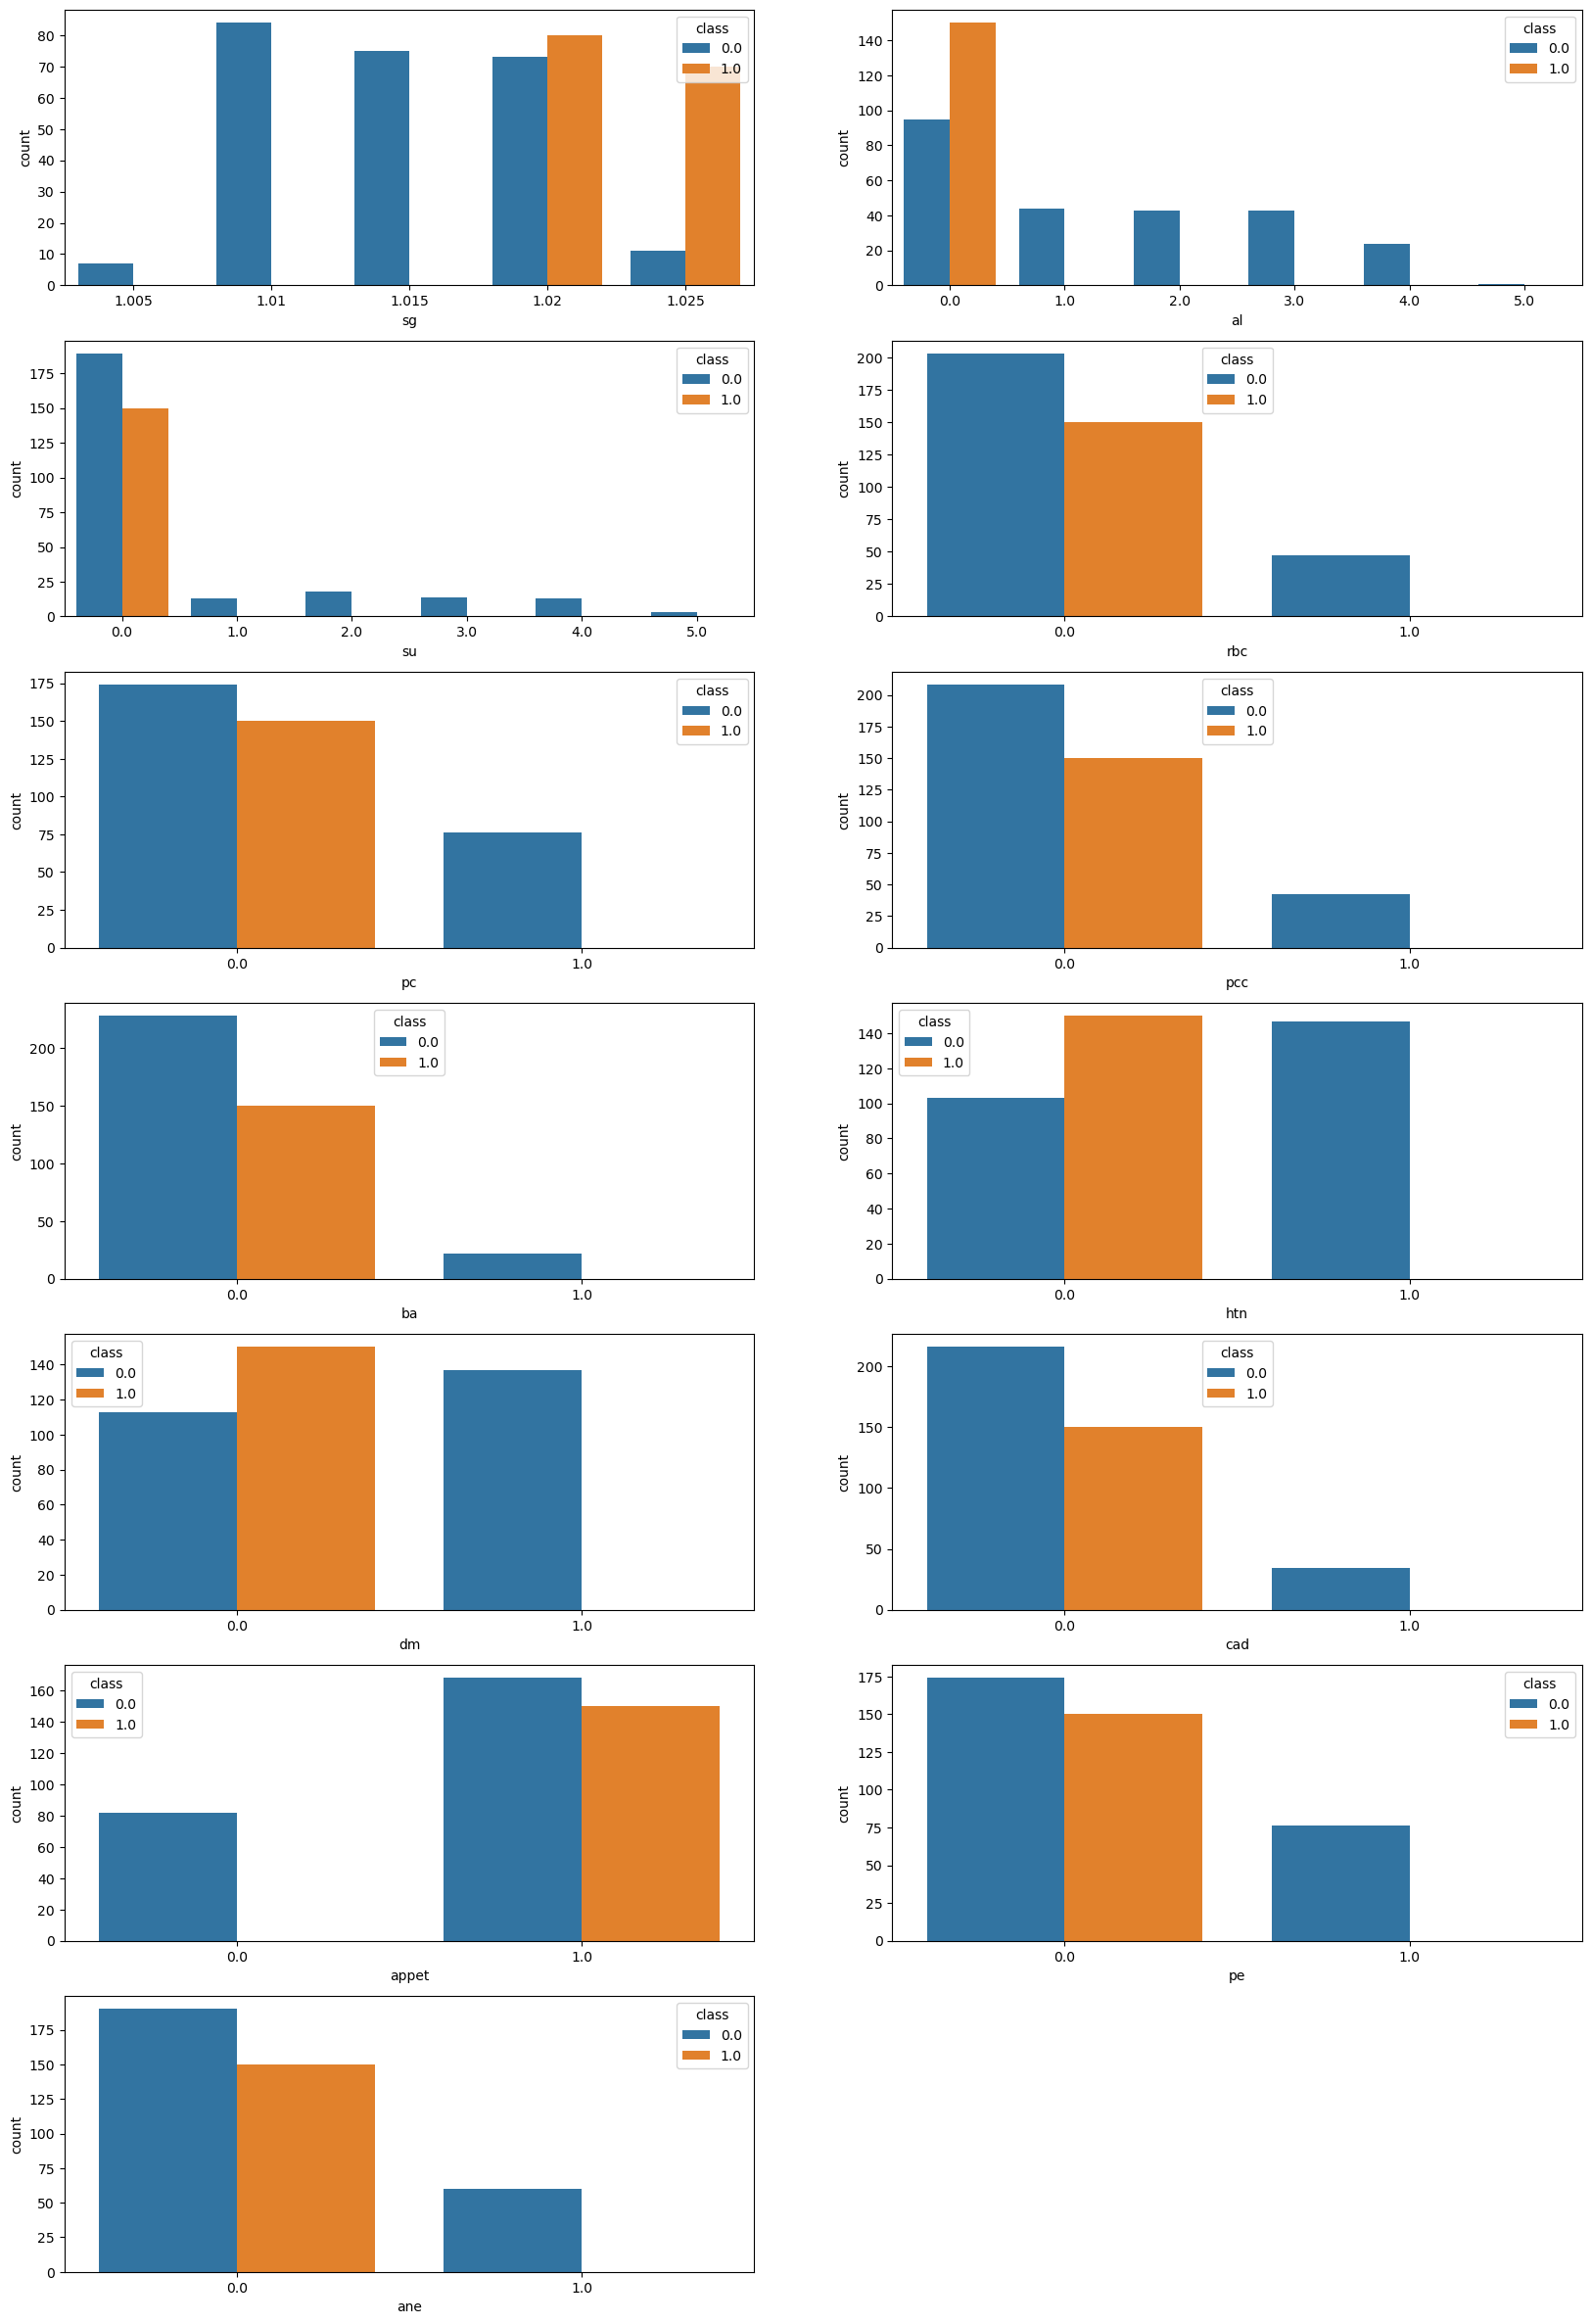

In [442]:
plt.figure(figsize = (20,30))
plot_number = 1
for column in category:
    if plot_number <= 14:
        ax = plt.subplot(7,2,plot_number)
        sns.countplot(x =column,hue='class',data = dataset)
    plot_number += 1
plt.show()

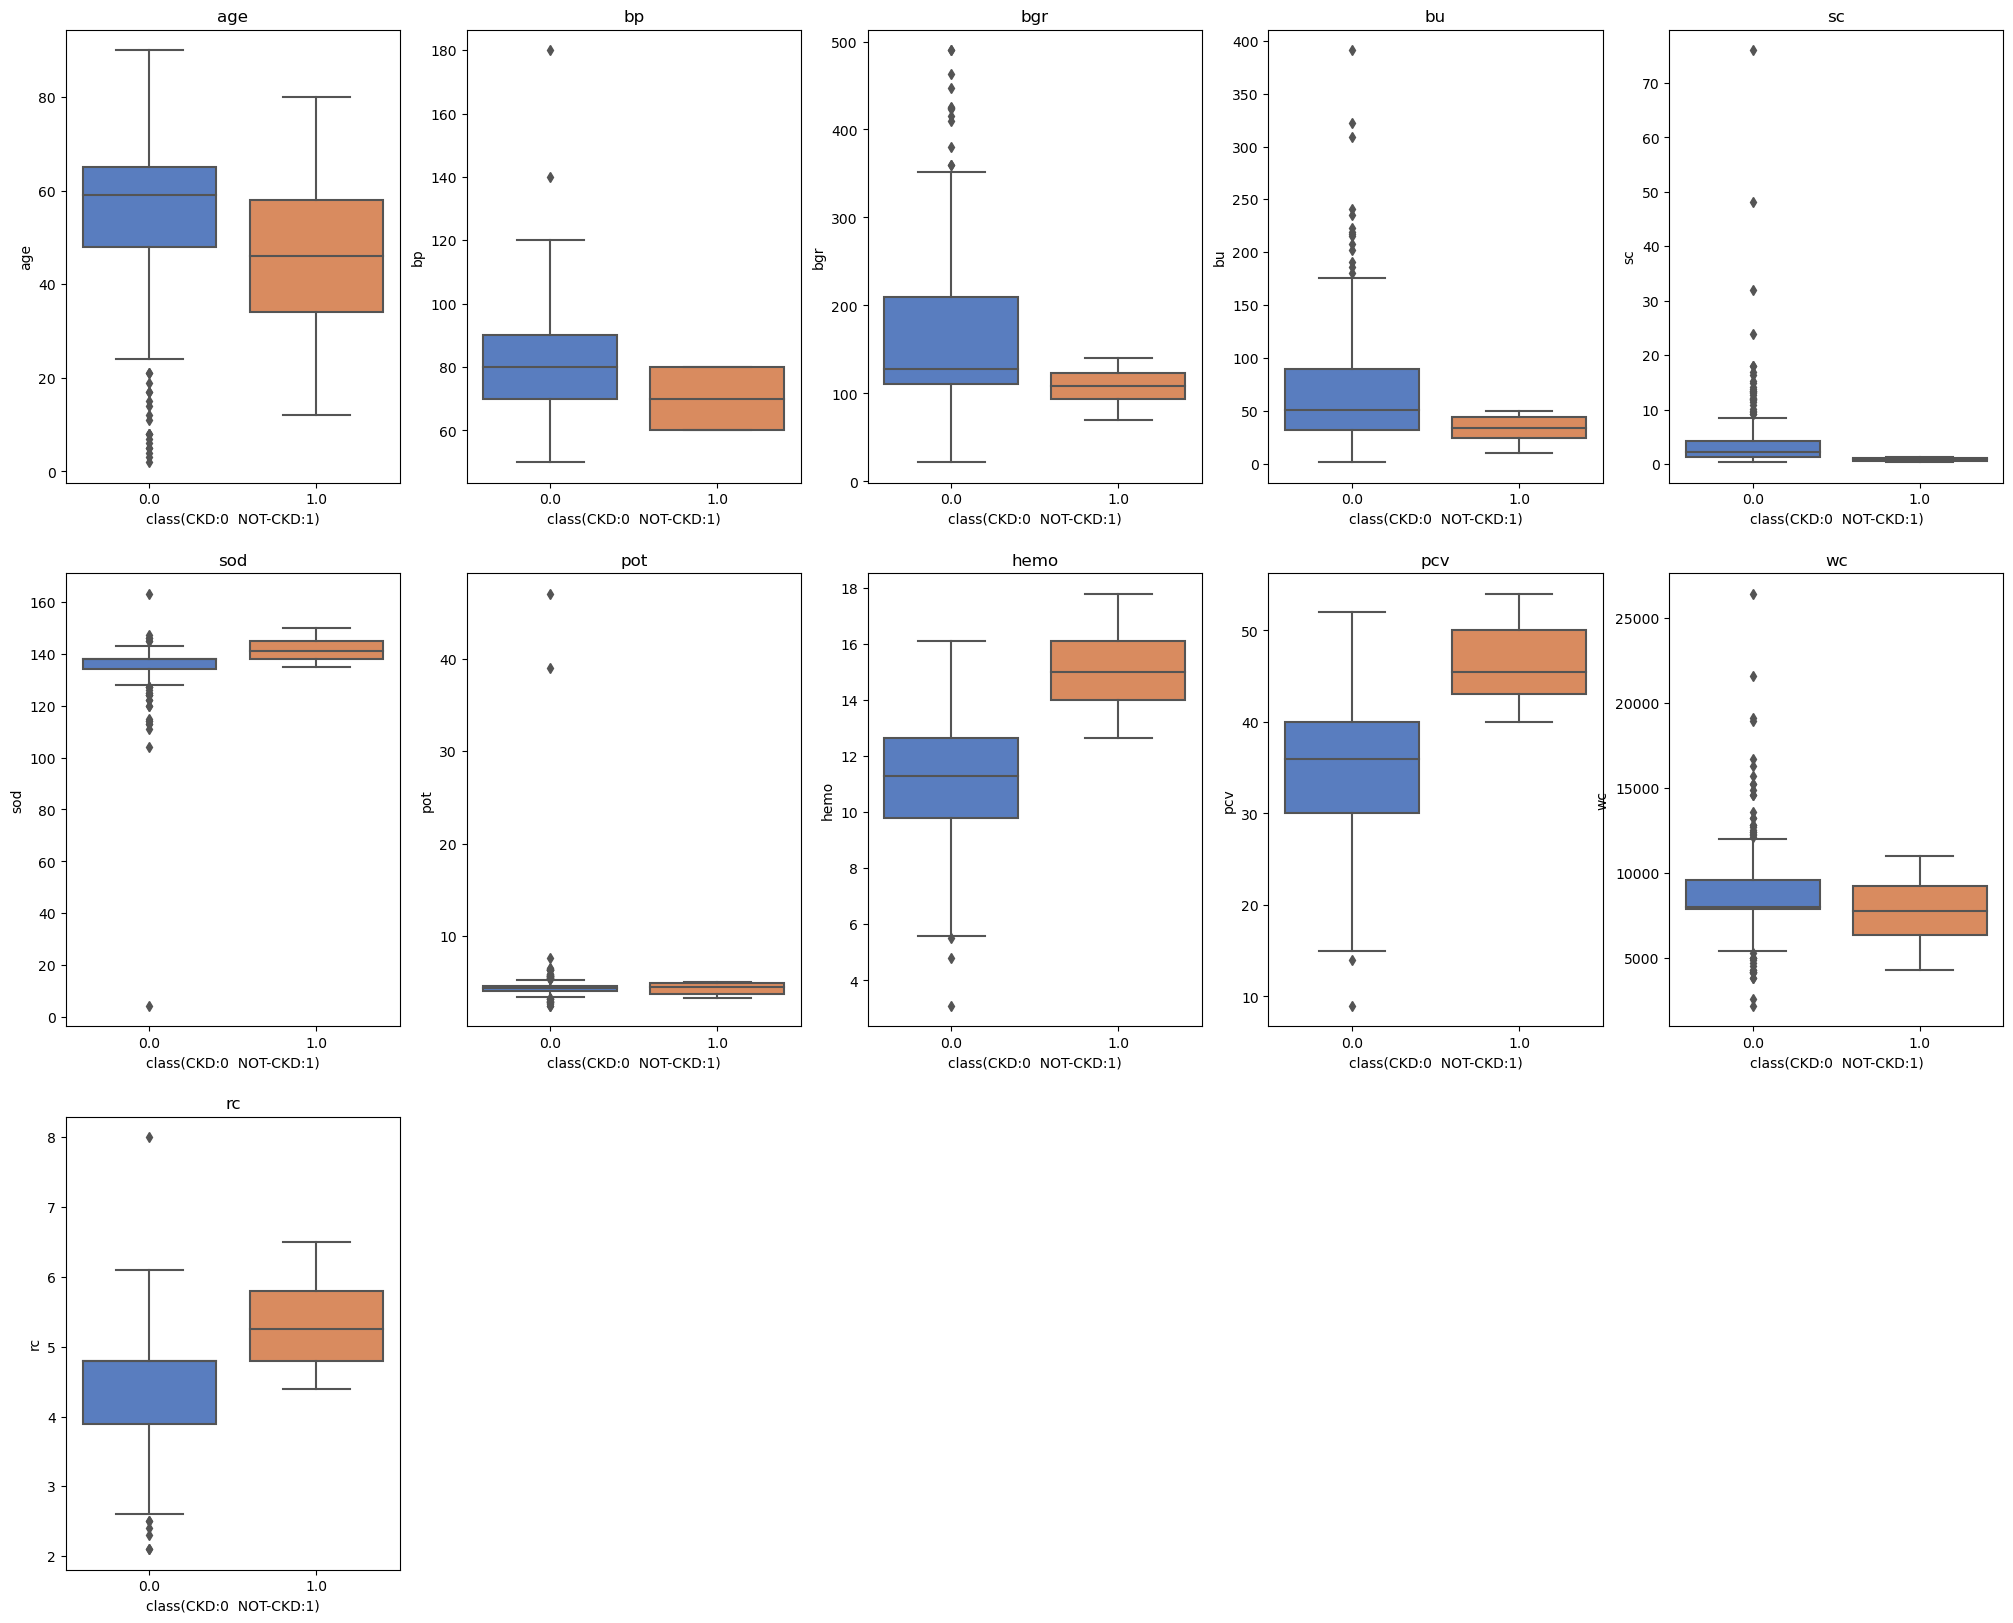

In [443]:
plt.figure(figsize = (25,20))
plot_number = 1
for column in numerical:
    if plot_number <= 14:
        ax = plt.subplot(3, 5, plot_number)
        sns.boxplot(data=dataset,
            x="class",
            y=column,
            palette = "muted"
           )
        ax.set_title(column)
        plt.xlabel("class(CKD:0  NOT-CKD:1)")
    plot_number += 1
plt.show()

In [444]:
co_mat = dataset.corr()

<AxesSubplot:>

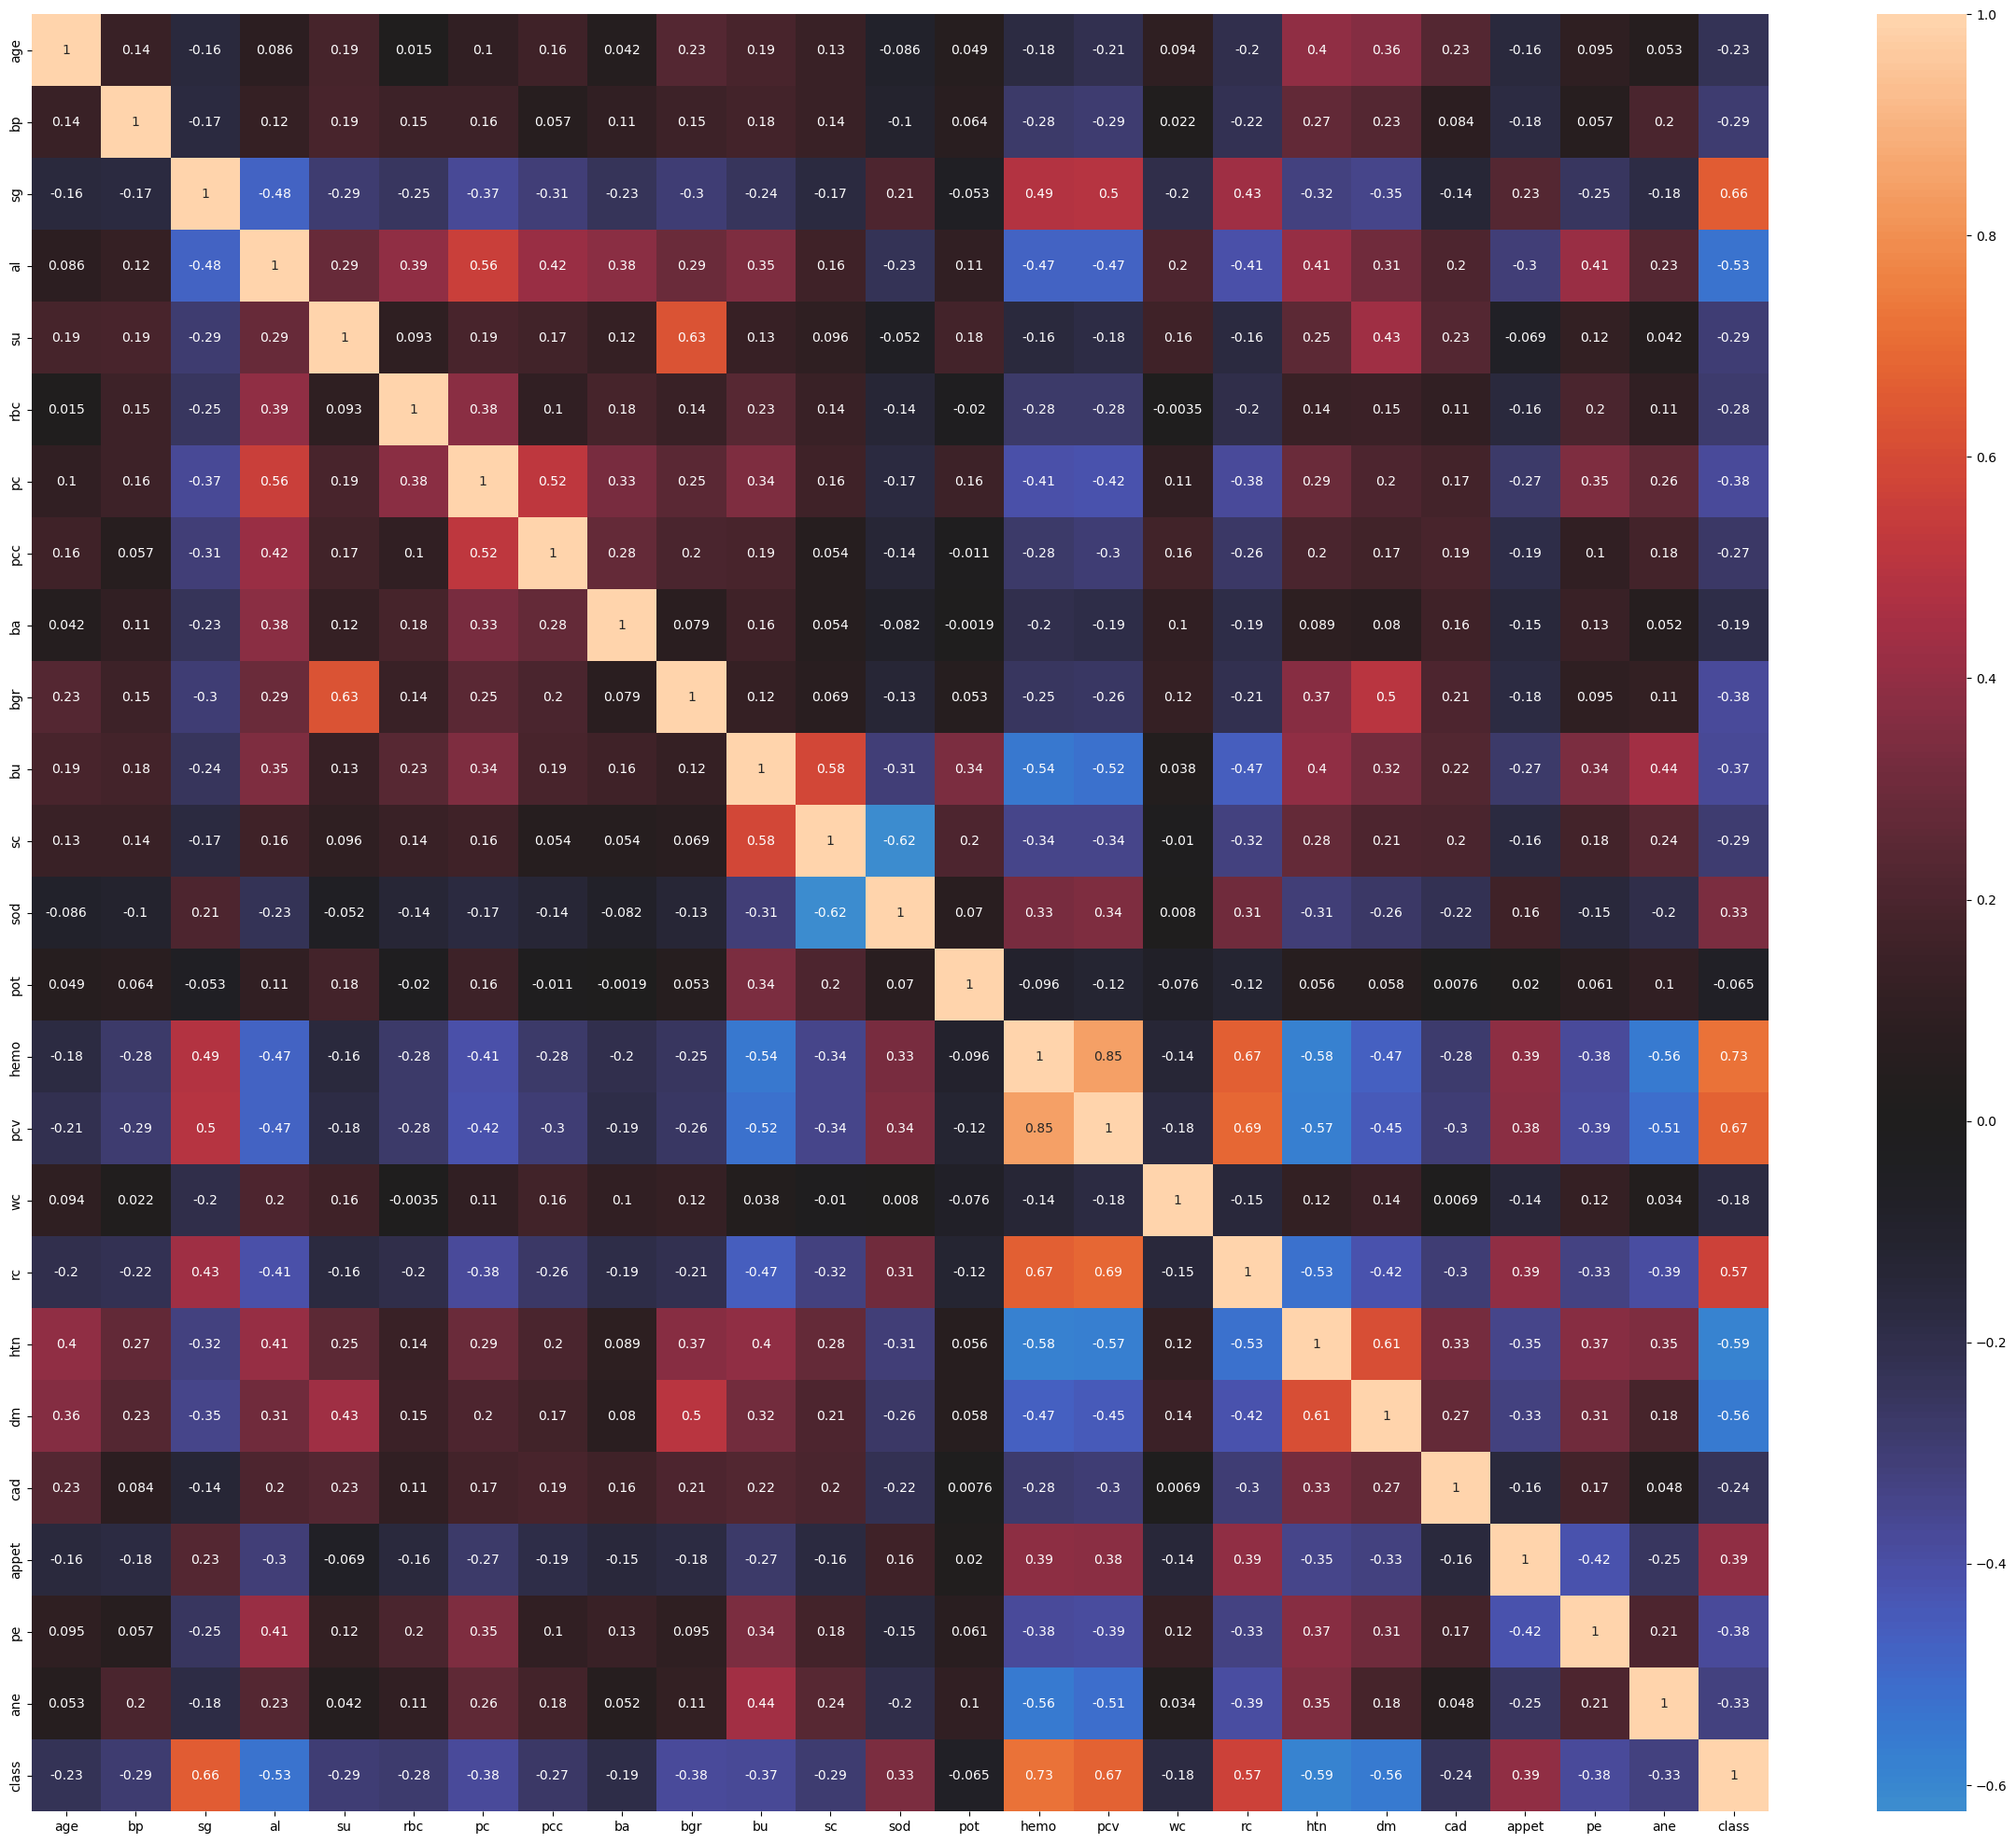

In [445]:
plt.figure(1, figsize=(30,25))
sns.heatmap(co_mat,center=0, annot=True, cbar=True)

In [446]:
X = dataset.drop('class', axis=1)
y = dataset['class']
df = pd.DataFrame(X)

acc_set=[]
prec_set=[]
f1_set=[]
kappa_set=[]
specificity_set=[]
sensitivity_set=[]

In [447]:
#DECISION TREE





Average accuracy score(Decision Tree): 97.74999999999999  %


hemo : 0.7367195767195767
sg : 0.19367071906512118
bu : 0.020086584503860985
htn : 0.019662614268212204
rc : 0.014906832298136618
pcv : 0.014222222222222221
sc : 0.0007314509228700961


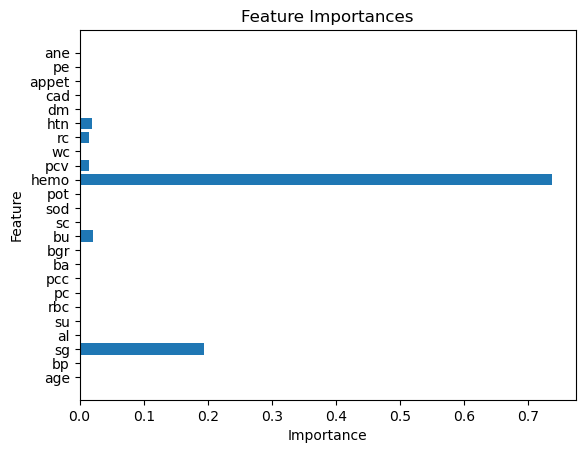

In [448]:
dt = DecisionTreeClassifier(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

print("\n")
print("Average accuracy score(Decision Tree):", sum(scores)/len(scores)*100," %")
print("\n")

importances = dt.feature_importances_
features = X.columns.tolist()

importance_dict = {features[i]: importances[i] for i in range(len(features))}

sorted_dict = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in range(7):
    print(sorted_dict[i][0], ":", sorted_dict[i][1])


plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()


In [449]:
#ENSEMBLE MODEL DEFINITION


indices = np.argsort(importances)[::-1]
selected_features = indices[:7]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Define the ensemble model with the selected features
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = SVC(random_state=42)
clf4 = KNeighborsClassifier()
clf5 = XGBClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3), ('knn', clf4), ('xgb', clf5)], voting='hard')

# Evaluate the accuracy using 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kf, scoring='accuracy')

print("Selected features:", X_train.columns[selected_features])


Selected features: Index(['hemo', 'sg', 'bu', 'htn', 'rc', 'pcv', 'sc'], dtype='object')


Confusion matrix:
[[241   9]
 [  6 144]]
Accuracy(DECISION TREE+MAX VOTING): 96.250000 %
Precision: 94.118 %
F1 score: 95.050 %
Kappa: 92.032 %
Specificity: 96.400 %
Sensitivity: 96.000 %


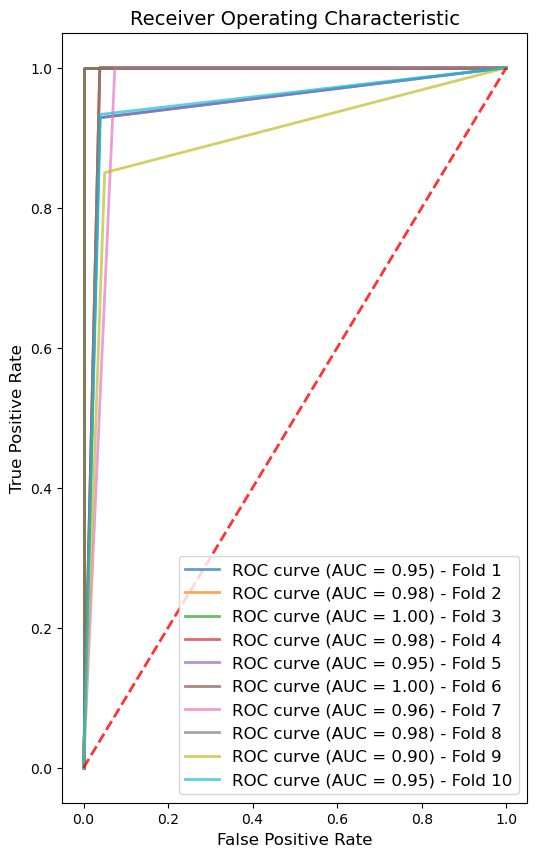

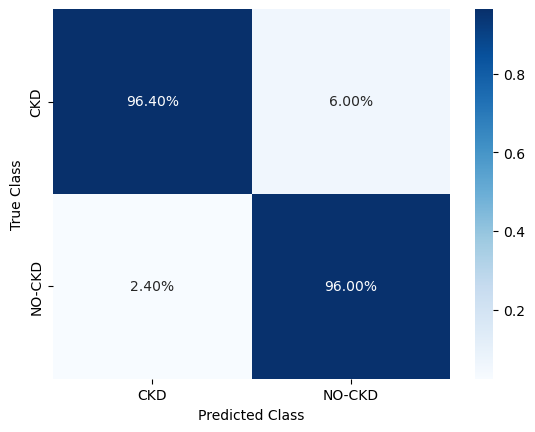

In [450]:
fig, ax = plt.subplots(figsize=(6, 10))

y_true = []
y_pred = []
y_prob = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_dt = X_train.iloc[:, selected_features]
    X_test_dt = X_test.iloc[:, selected_features]
    
    ensemble.fit(X_train_dt, y_train)
    y_true.extend(y_test)
    y_pred.extend(ensemble.predict(X_test_dt))
    y_prob_fold = np.where(ensemble.predict(X_test_dt) == 1, 1, 0)
    y_prob.extend(y_prob_fold)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, lw=2, alpha=0.7, label='ROC curve (AUC = %0.2f) - Fold %d' % (roc_auc, i+1))
    y_prob = []
    y_prob_fold=[]

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
accuracy=(tp+tn)/(tn+fp+fn+tp)
print("Accuracy(DECISION TREE+MAX VOTING): {:.6f} %".format(accuracy*100))
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Precision: {:.3f} %".format(precision * 100))
print("F1 score: {:.3f} %".format(f1 * 100))
print("Kappa: {:.3f} %".format(kappa * 100))
print("Specificity: {:.3f} %".format(specificity * 100))
print("Sensitivity: {:.3f} %".format(sensitivity * 100))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=14)
ax.legend(loc="lower right", fontsize=12)

plt.show()

cm_normalized = cm / np.sum(cm, axis=1)
xl = ['CKD', 'NO-CKD']
yl = ['CKD', 'NO-CKD']
sns.heatmap(cm_normalized, cmap="Blues", fmt='.2%', annot=True, cbar_kws={"orientation": "vertical"}, xticklabels=xl, yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

acc_set.append(accuracy)
prec_set.append(precision)
f1_set.append(f1)
kappa_set.append(kappa)
specificity_set.append(specificity)
sensitivity_set.append(sensitivity)

In [451]:
# XGBOOST





Average accuracy score(XGBOOST): 97.75  %


hemo : 0.52752113
sg : 0.19372477
sc : 0.08610082
al : 0.075645894
rc : 0.05673393
sod : 0.03298834
age : 0.01779807
bu : 0.008389759
wc : 0.0007278968
bgr : 0.00036936198


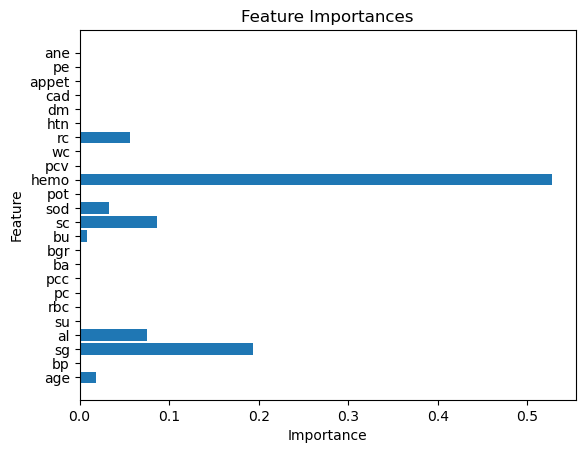

In [452]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xg_cl.fit(X_train, y_train)
    y_pred = xg_cl.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
            
print("\n")
print("Average accuracy score(XGBOOST):", sum(scores)/len(scores)*100," %")
print("\n")


importances = xg_cl.feature_importances_
features = X.columns.tolist()

importance_dict = {features[i]: importances[i] for i in range(len(features))}


sorted_dict = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in range(10):
    print(sorted_dict[i][0], ":", sorted_dict[i][1])


plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()


In [453]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

indices = np.argsort(importances)[::-1]
selected_features = indices[:10]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

acc_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kf, scoring='accuracy')

print("Selected features:", X_train.columns[selected_features])
print("Accuracy(XGBOOST+MAX VOTING): {:.6f} %".format(acc_scores.mean()*100))


Selected features: Index(['hemo', 'sg', 'sc', 'al', 'rc', 'sod', 'age', 'bu', 'wc', 'bgr'], dtype='object')
Accuracy(XGBOOST+MAX VOTING): 98.611111 %


Confusion matrix:
[[249   1]
 [  6 144]]


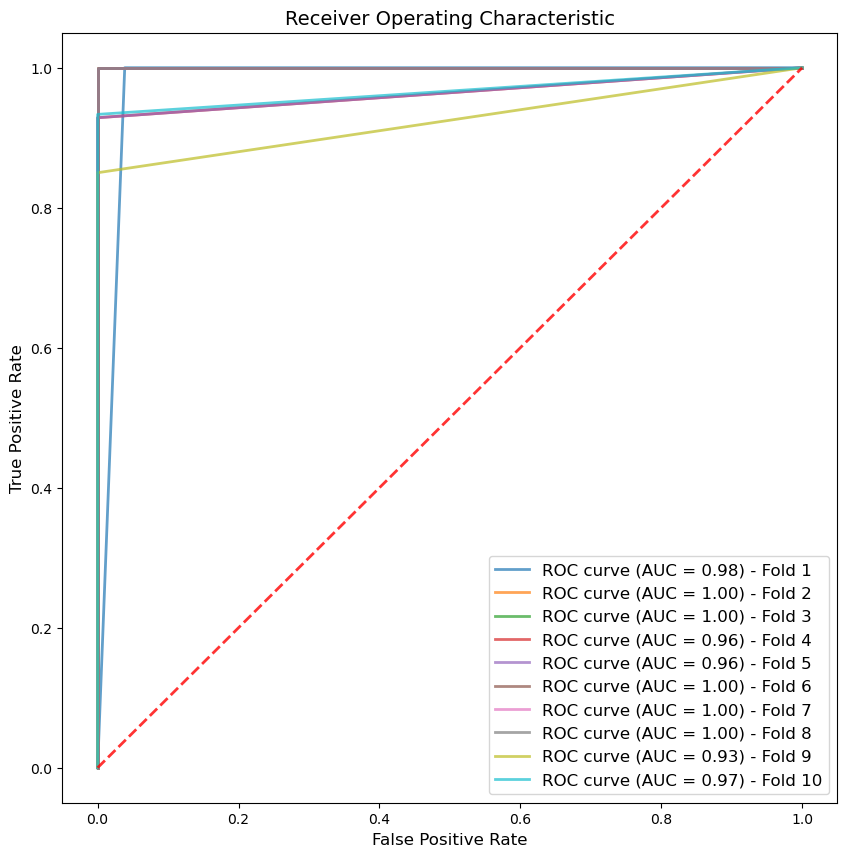

Accuracy(XGBOOST+MAX VOTING): 98.250000 %
Precision: 99.310 %
F1 score: 97.627 %
Kappa: 96.242 %
Specificity: 99.600 %
Sensitivity: 96.000 %


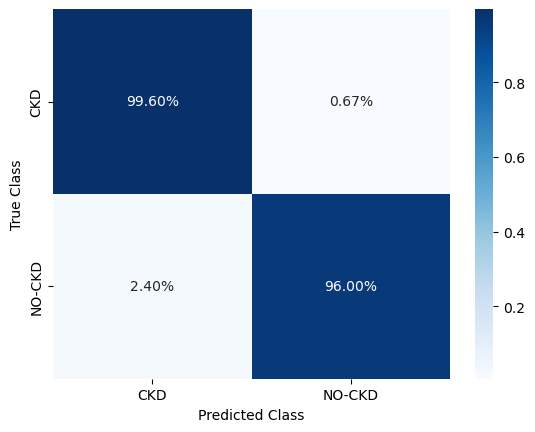

In [454]:
y_true = []
y_pred = []
y_prob=  []

#colors = plt.rainbow(np.linspace(0, 1,10))

fig, ax = plt.subplots(figsize=(10,10))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_xgb = X_train.iloc[:, selected_features]
    X_test_xgb = X_test.iloc[:, selected_features]
    
    ensemble.fit(X_train_xgb, y_train)
    
    y_true.extend(y_test)
    y_pred.extend(ensemble.predict(X_test_xgb))
    y_prob_fold = np.where(ensemble.predict(X_test_xgb) == 1, 1, 0)
    y_prob.extend(y_prob_fold)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.7, label='ROC curve (AUC = %0.2f) - Fold %d' % (roc_auc, i+1))
    y_prob=[]
    y_prob_fold=[]

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=14)
ax.legend(loc="lower right", fontsize=12)

plt.show()



precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
accuracy=(tp+tn)/(tn+fp+fn+tp)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Accuracy(XGBOOST+MAX VOTING): {:.6f} %".format(accuracy*100))
print("Precision: {:.3f} %".format(precision*100))
print("F1 score: {:.3f} %".format(f1*100))
print("Kappa: {:.3f} %".format(kappa*100))
print("Specificity: {:.3f} %".format(specificity*100))
print("Sensitivity: {:.3f} %".format(sensitivity*100))



cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show();


acc_set.append(accuracy)
prec_set.append(precision)
f1_set.append(f1)
kappa_set.append(kappa)
specificity_set.append(specificity)
sensitivity_set.append(sensitivity)

In [455]:
#RFE
#-------------------------------------------------------------------------------------------------------------------------------

In [456]:
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(estimator=estimator, n_features_to_select=8)

selector.fit(X_train, y_train)

selected_features = selector.get_support(indices=True)
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

selected_feature_names = X_train.columns[selected_features].tolist()

print("Best Features:", selected_feature_names)
print("Feature ranking:", selector.ranking_)
cv_scores = cross_val_score(selector, X, y, cv=10)


Best Features: ['sg', 'al', 'bgr', 'sc', 'hemo', 'pcv', 'rc', 'dm']
Feature ranking: [ 5  6  1  1  7 13 12 16 15  1  4  1  2 11  1  1 10  1  3  1 17  9  8 14]


[ 2  3  9 11 14 15 17 19]
Confusion Matrix:
 [[244   6]
 [  3 147]]
Accuracy(RFE+MAX VOTING): 97.750000 %
Precision: 96.078 %
F1 score: 97.030 %
Kappa: 95.219 %
Specificity: 97.600 %
Sensitivity: 98.000 %


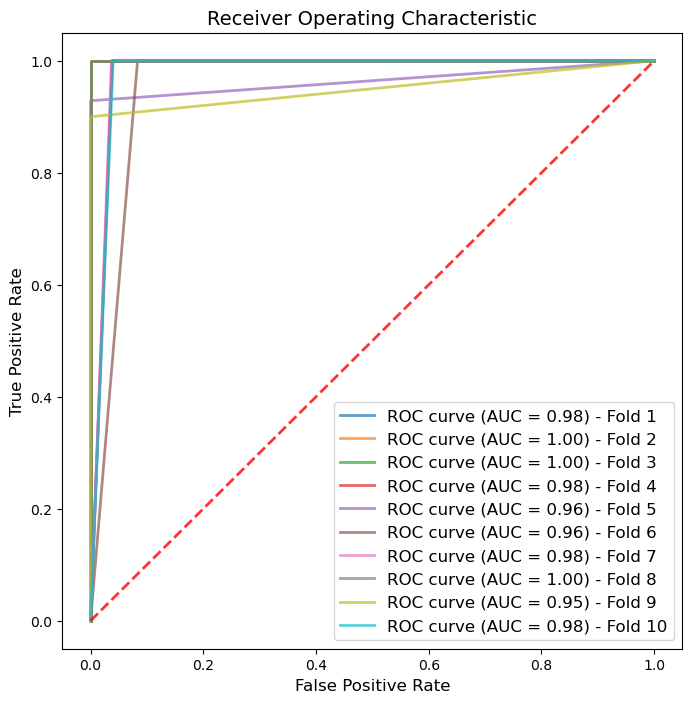

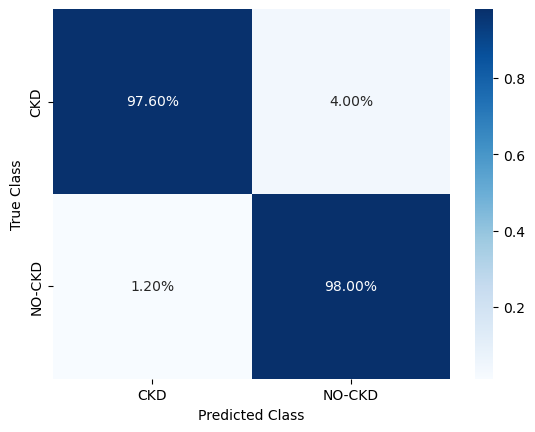

In [457]:
#----------------------------------------------------------------------------------------------------------------------------

y_true = []
y_pred = []
y_prob=  []

fig, ax = plt.subplots(figsize=(8,8))
print(selected_features)
for i,(train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_rfe=X_train.iloc[:,selected_features]
    X_test_rfe=X_test.iloc[:,selected_features]
    
    ensemble.fit(X_train_rfe, y_train)
    y_true.extend(y_test)
    y_pred.extend(ensemble.predict(X_test_rfe))
    y_prob_fold = np.where(ensemble.predict(X_test_rfe) == 1, 1, 0)
    y_prob.extend(y_prob_fold)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.7,label='ROC curve (AUC = %0.2f) - Fold %d' % (roc_auc, i+1))
    y_prob=[]
    y_prob_fold=[]

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)



precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy=(tp+tn)/(tn+fp+fn+tp)

print("Accuracy(RFE+MAX VOTING): {:.6f} %".format(accuracy*100))
print("Precision: {:.3f} %".format(precision*100))
print("F1 score: {:.3f} %".format(f1*100))
print("Kappa: {:.3f} %".format(kappa*100))
print("Specificity: {:.3f} %".format(specificity*100))
print("Sensitivity: {:.3f} %".format(sensitivity*100))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=14)
ax.legend(loc="lower right", fontsize=12)

plt.show()

cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.show()


acc_set.append(accuracy)
prec_set.append(precision)
f1_set.append(f1)
kappa_set.append(kappa)
specificity_set.append(specificity)
sensitivity_set.append(sensitivity)
#-----------------------------------------------------------------------------------------------------------------------------

Confusion Matrix:
 [[227  23]
 [ 12 138]]
Accuracy(LDA+MAX VOTING): 99.250000 %
Precision: 99.714 %
F1 score: 99.746 %
Kappa: 99.603 %
Specificity: 99.800 %
Sensitivity: 99.000 %


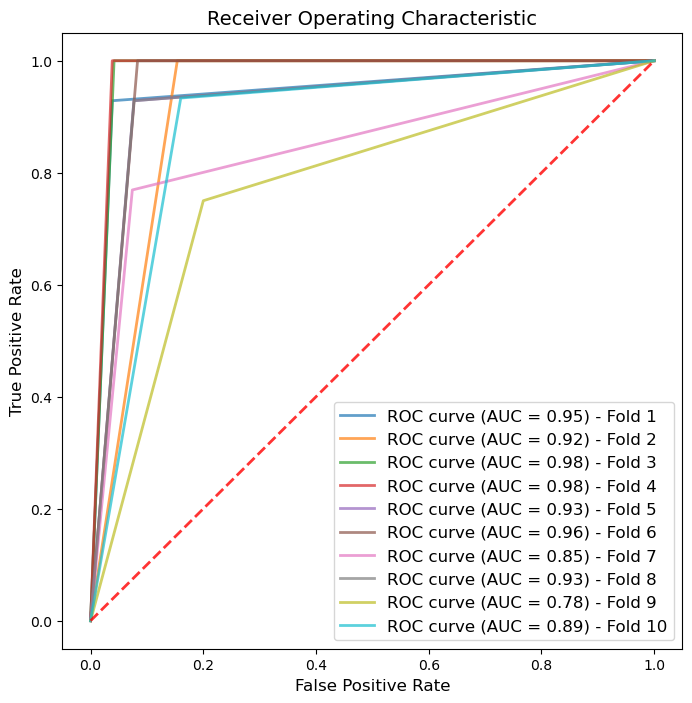

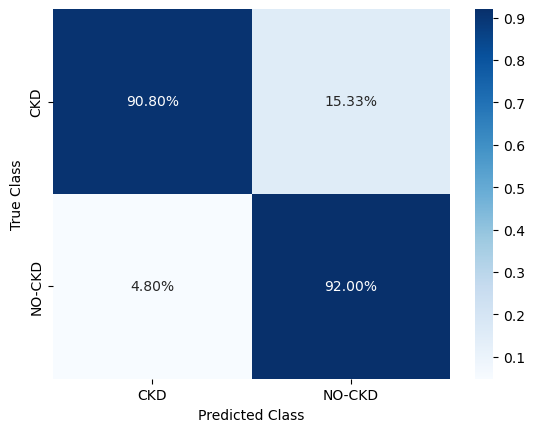

In [458]:
#LDA

lda = LinearDiscriminantAnalysis(n_components=1)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train_lda = lda.fit_transform(X_scaled, y)
X_test_lda = lda.transform(scaler.transform(X_test))

selected_features=[]
selected_feature = feature_names[lda.scalings_.argmax()]
index = df.columns.get_loc(selected_feature)
selected_features.append(index)
y_true = []
y_pred = []
y_prob = []

fig, ax = plt.subplots(figsize=(8, 8))

feature_names = X.columns.tolist()


for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_lda = X_train[:, selected_features]
    X_test_lda = X_test[:, selected_features]

    ensemble.fit(X_train_lda, y_train)
    y_pred_curr = ensemble.predict(X_test_lda)
    y_true.extend(y_test)
    y_pred.extend(y_pred_curr)
    y_prob_fold = np.where(ensemble.predict(X_test_lda) == 1, 1, 0)
    y_prob.extend(y_prob_fold)
   
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.7, label='ROC curve (AUC = %0.2f) - Fold %d' % (roc_auc, i + 1))
    y_prob=[]


cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

precision_lda = precision_score(y_true, y_pred)
f1_lda = f1_score(y_true, y_pred)
kappa_lda = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity_lda = tn / (tn + fp)
sensitivity_lda = tp / (tp + fn)
accuracy_lda=(tp+tn)/(tn+fp+fn+tp)


print("Accuracy(LDA+MAX VOTING): {:.6f} %".format(accuracy_lda*100))

print("Precision: {:.3f} %".format(precision_lda * 100))
print("F1 score: {:.3f} %".format(f1_lda * 100))
print("Kappa: {:.3f} %".format(kappa_lda * 100))
print("Specificity: {:.3f} %".format(specificity_lda * 100))
print("Sensitivity: {:.3f} %".format(sensitivity_lda * 100))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=14)
ax.legend(loc="lower right", fontsize=12)

plt.show()

cm_normalized = cm / np.sum(cm, axis=1)
xl = ['CKD', 'NO-CKD']
yl = ['CKD', 'NO-CKD']
sns.heatmap(cm_normalized, cmap="Blues", fmt='.2%', annot=True, cbar_kws={"orientation": "vertical"},
            xticklabels=xl, yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

acc_set.append(accuracy_lda)
prec_set.append(precision_lda)
f1_set.append(f1_lda)
kappa_set.append(kappa_lda)
specificity_set.append(specificity_lda)
sensitivity_set.append(sensitivity_lda)

In [459]:
#PCA
#-----------------------------------------------------------------------------------------------------------------------------

Selected Features: ['pcv', 'hemo', 'rc', 'htn', 'al']
Confusion Matrix:
[[244   6]
 [  4 146]]
Accuracy(PCA+MAX VOTING): 97.500000 %
Precision: 96.053 %
F1 score: 96.689 %
Kappa: 94.681 %
Specificity: 97.600 %
Sensitivity: 97.333 %


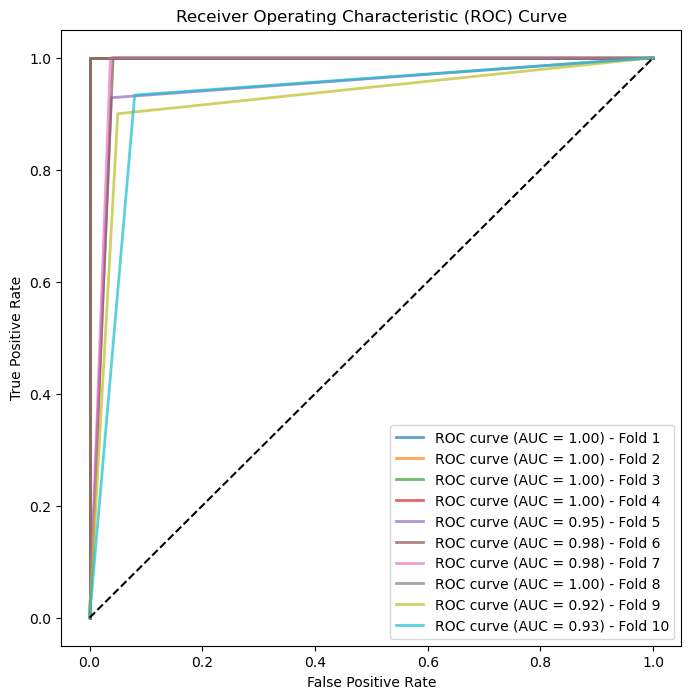

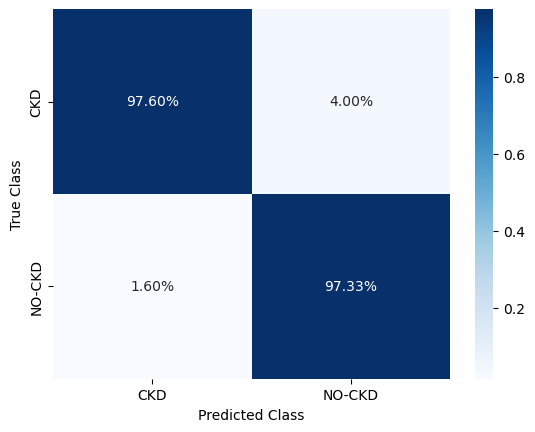

In [460]:
# PCA

scaler = StandardScaler()
scaler.fit(X)

selected_features=[]
X_scaled = scaler.transform(X)

pca = PCA(n_components=5)
pca.fit(X_scaled)

selected_feature_indices = np.argsort(np.abs(pca.components_[0]))[::-1][:5]
selected_feature_names = X.columns[selected_feature_indices].tolist()

for i in selected_feature_names:
    index = df.columns.get_loc(i)
    selected_features.append(index)

y_true = []
y_pred = []
y_prob_fold=[]
y_prob=[]
clf = LogisticRegression()  # Replace YourClassifier with the actual classifier you are using

fig, ax = plt.subplots(figsize=(8, 8))

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_select=X_train.iloc[:,selected_features]
    X_test_select=X_test.iloc[:,selected_features]
    
    X_train_scaled = scaler.fit_transform(X_train_select)
    X_test_scaled = scaler.transform(X_test_select)

    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    ensemble.fit(X_train_pca, y_train)

    y_pred_curr = ensemble.predict(X_test_pca)
   
    y_true.extend(y_test)
    y_pred.extend(y_pred_curr)
    y_prob_fold=np.where(ensemble.predict(X_test_pca) == 1, 1, 0)
    y_prob.extend(y_prob_fold)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.7, label='ROC curve (AUC = %0.2f) - Fold %d' % (roc_auc, i + 1))
    y_prob=[]
    y_prob_fold=[]


print("Selected Features:", selected_feature_names)

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy=(tp+tn)/(tn+fp+fn+tp)

print("Accuracy(PCA+MAX VOTING): {:.6f} %".format(accuracy*100))
print("Precision: {:.3f} %".format(precision * 100))
print("F1 score: {:.3f} %".format(f1 * 100))
print("Kappa: {:.3f} %".format(kappa * 100))
print("Specificity: {:.3f} %".format(specificity * 100))
print("Sensitivity: {:.3f} %".format(sensitivity * 100))

ax.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

cm_normalized = cm / np.sum(cm, axis=1)
xl = ['CKD', 'NO-CKD']
yl = ['CKD', 'NO-CKD']
# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, cmap="Blues", fmt='.2%', annot=True, cbar_kws={"orientation": "vertical"}, xticklabels=xl, yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()



acc_set.append(accuracy)
prec_set.append(precision)
f1_set.append(f1)
kappa_set.append(kappa)
specificity_set.append(specificity)
sensitivity_set.append(sensitivity)

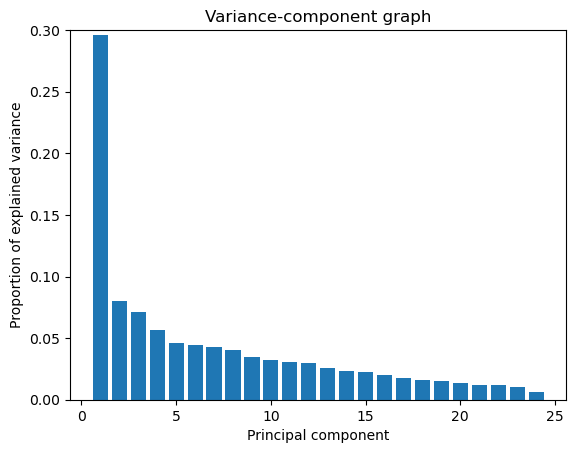

In [461]:
scaler = StandardScaler()
pca1 = PCA(n_components=24)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_pca = pca1.fit_transform(X_train_scaled)
    

plt.bar(range(1,25), pca1.explained_variance_ratio_, align='center')
plt.title('Variance-component graph')
plt.xlabel('Principal component')
plt.ylabel('Proportion of explained variance')
plt.ylim(0,0.3)
plt.show()


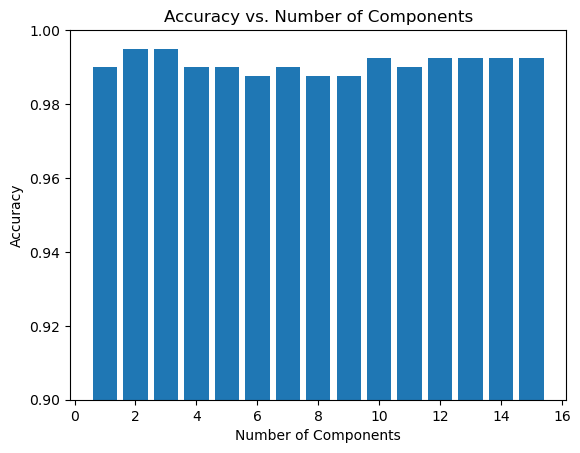

In [462]:
scores=[]
num_components = []
y_true=[]
y_pred=[]
for i in range(1,16):
    pca = PCA(n_components=i)
    fold_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        ensemble.fit(X_train_pca, y_train)

        y_pred_fold = ensemble.predict(X_test_pca)

        fold_scores.append(accuracy_score(y_test, y_pred_fold))

    avg_score = sum(fold_scores) / len(fold_scores)

    num_components.append(i)
    scores.append(avg_score)

plt.bar(num_components, scores)
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1)
plt.show()

In [463]:
#mrmr
#-----------------------------------------------------------------------------------------------------------------------------

100%|██████████| 8/8 [00:00<00:00, 22.90it/s]


Selected Features: ['hemo', 'sg', 'pcv', 'dm', 'htn', 'al', 'rc', 'sod']
Confusion Matrix:
[[246   4]
 [  4 146]]
Accuracy(mrmr+MAX VOTING): 98.000000 %
Precision: 97.333 %
F1 score: 97.333 %
Kappa: 95.733 %
Specificity: 98.400 %
Sensitivity: 97.333 %


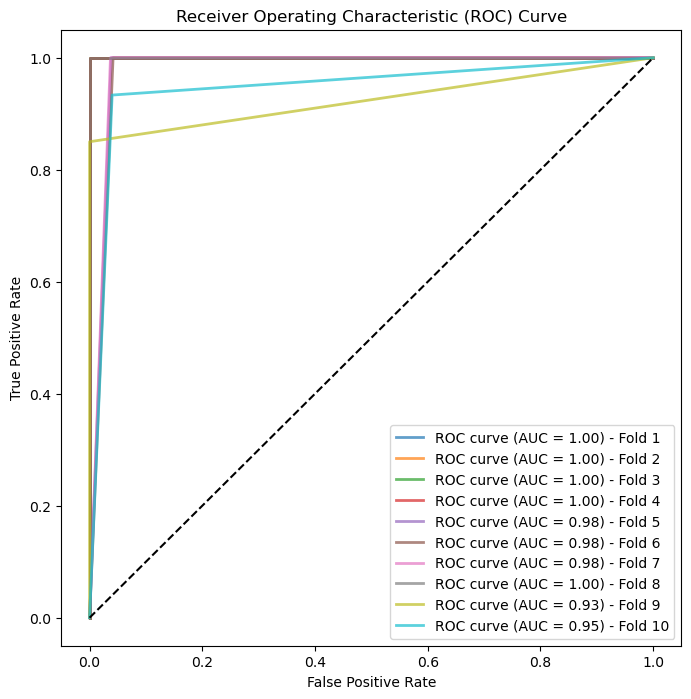

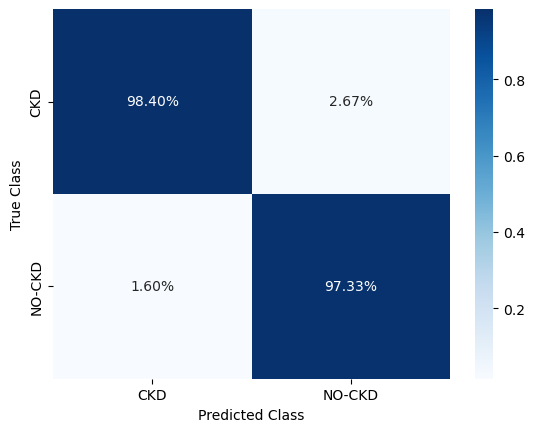

In [464]:
fig, ax = plt.subplots(figsize=(8, 8))
y_true = []
y_pred = []
y_prob=[]

selected_features = mrmr_classif(X_train, y_train, K=8)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_mrmr = X_train.loc[:, selected_features]
    X_test_mrmr = X_test.loc[:, selected_features]

    ensemble.fit(X_train_mrmr, y_train)

    y_pred_fold = ensemble.predict(X_test_mrmr)

    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    
    y_prob_fold=np.where(ensemble.predict(X_test_mrmr) == 1, 1, 0)
    y_prob.extend(y_prob_fold)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.7, label='ROC curve (AUC = %0.2f) - Fold %d' % (roc_auc, i + 1))
    y_prob=[]
    y_prob_fold=[]

print("Selected Features:", selected_features)

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy=(tp+tn)/(tn+fp+fn+tp)

print("Accuracy(mrmr+MAX VOTING): {:.6f} %".format(accuracy*100))
print("Precision: {:.3f} %".format(precision * 100))
print("F1 score: {:.3f} %".format(f1 * 100))
print("Kappa: {:.3f} %".format(kappa * 100))
print("Specificity: {:.3f} %".format(specificity * 100))
print("Sensitivity: {:.3f} %".format(sensitivity * 100))

ax.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

cm_normalized = cm / np.sum(cm, axis=1)
xl = ['CKD', 'NO-CKD']
yl = ['CKD', 'NO-CKD']
# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, cmap="Blues", fmt='.2%', annot=True, cbar_kws={"orientation": "vertical"}, xticklabels=xl, yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


acc_set.append(accuracy)
prec_set.append(precision)
f1_set.append(f1)
kappa_set.append(kappa)
specificity_set.append(specificity)
sensitivity_set.append(sensitivity)

In [487]:
classifier = ['DT', 'XGB', 'RFE', 'LDA', 'PCA', 'mRmR']
print("Features\tAccuracy\tSpecificity\tSensitivity\tPrecision\tF1 score\tKappa")

for j in range(len(classifier)):
    accuracy = round(acc_set[j]*100, 4)
    specificity = round(specificity_set[j]*100, 4)
    sensitivity = round(sensitivity_set[j]*100, 4)
    precision = round(prec_set[j]*100, 4)
    f1_score = round(f1_set[j]*100, 4)
    kappa = round(kappa_set[j], 4)
    
    print(f"{classifier[j]}\t\t{accuracy}\t\t{specificity}\t\t{sensitivity}\t\t{precision}\t\t{f1_score}\t\t{kappa}")

Features	Accuracy	Specificity	Sensitivity	Precision	F1 score	Kappa
DT		96.25		96.4		96.0		94.1176		95.0495		0.9203
XGB		98.25		99.6		96.0		99.3103		97.6271		0.9624
RFE		97.75		97.6		98.0		96.0784		97.0297		0.9522
LDA		99.25		99.8		99.0		99.7143		99.746		0.996
PCA		97.5		97.6		97.3333		96.0526		96.6887		0.9468
mRmR		98.0		98.4		97.3333		97.3333		97.3333		0.9573
